Connected to transformer (Python 3.9.18)

Norm Param:  -11253.037757903623 -11799.487235321754 19549.43678019075 55780.95723182413 45234.0 112.0
c1_data shape: (2048, 2048, 80)
c2_data shape: (2048, 2048, 80)
80


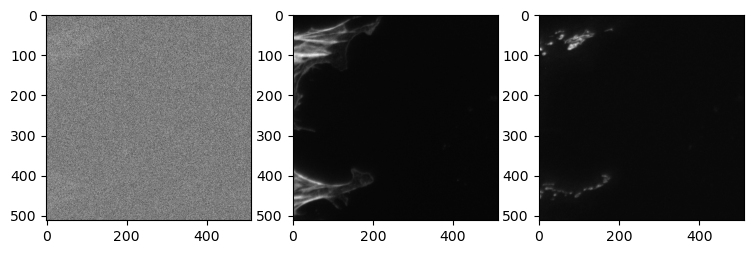

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from skimage.transform import resize
import matplotlib.pyplot as plt


    
def load_data(data_type, mode='Train'):
    if data_type == 'biosr':
        directory = '/group/jug/ashesh/TrainValTestSplit/biosr'
    elif data_type == 'hagen':
        directory = '/group/jug/ashesh/TrainValTestSplit/hagen'
    
    if mode == 'Train':
        train = np.load(os.path.join(directory, 'train_data.npy'), allow_pickle=True)
        return train
    elif mode =='Val':
        val = np.load(os.path.join(directory, 'val_data.npy'), allow_pickle=True)
        return val
    elif mode =='Test':
        test = np.load(os.path.join(directory, 'test_data.npy'), allow_pickle=True)
        return test
    else:
        raise ValueError('Invalid mode')

class SplitDataset(Dataset):    
    """Dataset class to load images from MRC files in multiple folders."""
    def __init__(self, patch_size=64, data_type='biosr', transform=None, noisy_data = False, noise_factor = 1000, gaus_factor = 2000, mode = 'Train'): #TODO
        """
        Args:
            root_dir (string): Root directory containing subdirectories of MRC files.
            transform (callable, optional): Optional transform to be applied on a sample.
            resize_to_shape: For development, we can downscale the data to fit in the meomory constraints
        """
        self.transform = transform     
        self.mode = mode 
        self.data_type = data_type  
        
        self.data = load_data(data_type=data_type, mode = self.mode)
        
        self.c1_data = self.data[...,0:1]
        self.c2_data = self.data[...,1:2]
        
        self.c1_data = np.squeeze(self.c1_data, axis = -1)
        self.c2_data = np.squeeze(self.c2_data, axis = -1)

        self.c1_data = np.transpose(self.c1_data, (1,2,0))
        self.c2_data = np.transpose(self.c2_data, (1,2,0))
        
        self.patch_size = patch_size
        self.noisy_data = noisy_data
        self.noise_factor = noise_factor   
        self.gaus_factor = gaus_factor           
             
        
        if self.noisy_data: 
            if self.noise_factor == 0:
                self.poisson_noise_channel_1 = self.c1_data
                self.poisson_noise_channel_2 = self.c2_data
            else: 
                self.poisson_noise_channel_1 = np.random.poisson(self.c1_data / self.noise_factor) * self.noise_factor
                self.poisson_noise_channel_2= np.random.poisson(self.c2_data / self.noise_factor) * self.noise_factor
                
            self.gaussian_noise_channel_1= np.random.normal(0,self.gaus_factor, (self.poisson_noise_channel_1.shape))
            self.gaussian_noise_channel_2 = np.random.normal(0,self.gaus_factor, (self.poisson_noise_channel_2.shape))
            self.c1_data_noisy = self.poisson_noise_channel_1 + self.gaussian_noise_channel_1
            self.c2_data_noisy = self.poisson_noise_channel_2 + self.gaussian_noise_channel_2          
            self.c1_min = np.min(self.c1_data_noisy) 
            self.c2_min = np.min(self.c2_data_noisy)
            self.c1_max = np.max(self.c1_data_noisy)
            self.c2_max = np.max(self.c2_data_noisy)
        else:
            self.c1_min = np.min(self.c1_data) 
            self.c2_min = np.min(self.c2_data)
            self.c1_max = np.max(self.c1_data)
            self.c2_max = np.max(self.c2_data) 
        self.input_min = np.min(self.c1_data[:,:,:self.c1_data.shape[-1]]+self.c2_data[:, :, :self.c1_data.shape[-1]])
        self.input_max = np.max(self.c1_data[:,:,:self.c2_data.shape[-1]]+self.c2_data[:, :,:self.c2_data.shape[-1]]) #TODO da cambiare trovare un modeo per trovare la lunghezza
        
        print("Norm Param: ", self.c1_min, self.c2_min, self.c1_max, self.c2_max,self.input_max, self.input_min)
        
        print(f"c1_data shape: {self.c1_data.shape}")
        print(f"c2_data shape: {self.c2_data.shape}")
        
    def __len__(self):
        # Use the first dimension to determine the number of images
        return min(self.c1_data.shape[-1], self.c2_data.shape[-1])

    def __getitem__(self, idx):
        n_idx, h, w = self.patch_location(idx)
        data_channel1 = self.c1_data[h:h+self.patch_size,w:w+self.patch_size, n_idx].astype(np.float32)
        data_channel2 = self.c2_data[h:h+self.patch_size,w:w+self.patch_size, n_idx].astype(np.float32) 

        sample1 = {'image': data_channel1}
        sample2 = {'image': data_channel2}

        if self.noisy_data:
            data_channel1_noisy = self.c1_data_noisy[h:h+self.patch_size,w:w+self.patch_size, n_idx].astype(np.float32)
            data_channel2_noisy = self.c2_data_noisy[h:h+self.patch_size,w:w+self.patch_size, n_idx].astype(np.float32)
            noisy_sample_1 = {'image': data_channel1_noisy}
            noisy_sample_2 = {'image': data_channel2_noisy}        
        
            if self.transform:
                transformed = self.transform(image = sample1['image'], image0=sample2['image'], 
                                            noisy_image_1=noisy_sample_1['image'], noisy_image_2=noisy_sample_2['image'])
                
                sample1['image'] = transformed['image']
                sample2['image'] = transformed['image0']
                noisy_sample_1['image'] = transformed['noisy_image_1']
                noisy_sample_2['image'] = transformed['noisy_image_2'] 
                           
            input_image = noisy_sample_1['image'] + noisy_sample_2['image']
        
        else:
            if self.transform:
                transformed = self.transform(image = sample1['image'], image0=sample2['image'])
                sample1['image'] = transformed['image']
                sample2['image'] = transformed['image0']
            
            input_image = sample1['image'] + sample2['image']
        
        input_image = (input_image - self.input_min) / (self.input_max - self.input_min) 
        input_image = input_image.astype(np.float32)
        sample1['image'] = (sample1['image'] - self.c1_min) / (self.c1_max - self.c1_min)  # Min-Max Normalization
        sample2['image'] = (sample2['image'] - self.c2_min) / (self.c2_max - self.c2_min)  # Min-Max Normalization
        
        target = np.stack((sample1['image'], sample2['image']))        
        target = target.astype(np.float32)        
        return input_image, target
    
    def get_normalization_params(self):
        return self.c1_min, self.c1_max, self.c2_min, self.c2_max   
    
    def patch_location(self, index):
        # it just ignores the index and returns a random location
        n_idx = np.random.randint(0,len(self))
        h = np.random.randint(0, self.c1_data.shape[0]-self.patch_size) 
        w = np.random.randint(0, self.c1_data.shape[1]-self.patch_size)
        return (n_idx, h, w)
   
    

if __name__ == '__main__':
    dataset = SplitDataset(mode='Train', patch_size=512, data_type='hagen', noisy_data=True)
    print(len(dataset))
    inp, tar = dataset[0]
    import matplotlib.pyplot as plt
    _,ax = plt.subplots(figsize=(9,3),ncols=3)
    ax[0].imshow(inp, cmap='gray')
    ax[1].imshow(tar[0], cmap='gray')
    ax[2].imshow(tar[1], cmap='gray')

Restarted transformer (Python 3.9.18)